# Federal University of Pampa <www.unipampa.edu.br>
### Authors: Brenda Silveira, Renata Ribeiro e Sandro Camargo <sandrocamargo@unipampa.edu.br>
### Blood Cell Classification using Convolutional Neural Networks
### Dataset: https://www.kaggle.com/datasets/paultimothymooney/blood-cells?resource=download


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.metrics import Precision, Recall
import os
import kagglehub
from google.colab import drive

# CONFIGURAÇÕES DE REPRODUTIBILIDADE

In [2]:
os.environ['PYTHONHASHSEED'] = '1'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(1)
tf.random.set_seed(1)

# PARÂMETROS GERAIS

In [3]:
IMAGE_WIDTH, IMAGE_HEIGHT = 480, 360 #320, 240 #640, 480
BATCH_SIZE = 96
EPOCHS = 100
VAL_SPLIT = 0.2
SEED = 1

# DOWNLOAD DO DATASET

In [4]:
base_path = kagglehub.dataset_download("paultimothymooney/blood-cells")
train_dir = f"{base_path}/dataset2-master/dataset2-master/images/TRAIN"
test_dir  = f"{base_path}/dataset2-master/dataset2-master/images/TEST"

print(f"Dataset baixado em: {base_path}")

Using Colab cache for faster access to the 'blood-cells' dataset.
Dataset baixado em: /kaggle/input/blood-cells


# FUNÇÃO: CRIAÇÃO DOS DATASETS

In [5]:
def create_datasets(train_path, img_size, batch_size, val_split, seed):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        validation_split=val_split,
        subset="training",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        validation_split=val_split,
        subset="validation",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size
    )

    class_names = train_ds.class_names
    print("Classes:", class_names)

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = (
        train_ds
        .shuffle(buffer_size=1000)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, class_names

train_ds, val_ds, class_names = create_datasets(
    train_dir,
    img_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    val_split=VAL_SPLIT,
    seed=SEED
)

Found 9957 files belonging to 4 classes.
Using 7966 files for training.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.
Classes: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


# MODELO CNN

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

#data_augmentation = tf.keras.Sequential([
    # --- Geometric augmentations ---
#    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # include vertical flip if appropriate
#    tf.keras.layers.RandomRotation(0.15),                   # slightly stronger
#    tf.keras.layers.RandomZoom(0.2),
#    tf.keras.layers.RandomTranslation(0.1, 0.1),            # small shifts

    # --- Photometric augmentations ---
#    tf.keras.layers.RandomContrast(0.2),                    # vary contrast
#    tf.keras.layers.RandomBrightness(factor=0.2),           # vary brightness (TF >= 2.17)

    # --- Optional: slight perspective/affine effects ---
#    tf.keras.layers.RandomCrop(IMAGE_HEIGHT, IMAGE_WIDTH),  # crop and recenter
#])

model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),  # <— camada de entrada explícita
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ============================================================
# CALLBACKS
# ============================================================
callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    CSVLogger('training_log.csv', append=False)
]

model.summary()

# ============================================================
# TREINAMENTO
# ============================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 360, 480, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 360, 480, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 360, 480, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 360, 480, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 180, 240, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 180, 240, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 90, 120, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 120, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 45, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 345600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    22,118,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,258,148 (84.91 MB)

 Trainable params: 22,258,148 (84.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.2468 - loss: 1.4691
Epoch 1: val_accuracy improved from -inf to 0.24561, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.2468 - loss: 1.4684 - val_accuracy: 0.2456 - val_loss: 1.3860
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.2491 - loss: 1.3862
Epoch 2: val_accuracy improved from 0.24561 to 0.29533, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 194ms/step - accuracy: 0.2491 - loss: 1.3862 - val_accuracy: 0.2953 - val_loss: 1.3851
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.2725 - loss: 1.3834
Epoch 3: val_accuracy improved from 0.29533 to 0.32396, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 193ms/step - accuracy: 0.2725 - loss: 1.3834 - val_accuracy: 0.3240 - val_loss: 1.3654
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3065 - loss: 1.3658
Epoch 4: val_accuracy improved fro

In [7]:
drive.mount('/content/drive')
!cp best_model.keras /content/drive/MyDrive/
!cp training_log.csv /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# VISUALIZAÇÃO DAS CURVAS DE TREINAMENTO

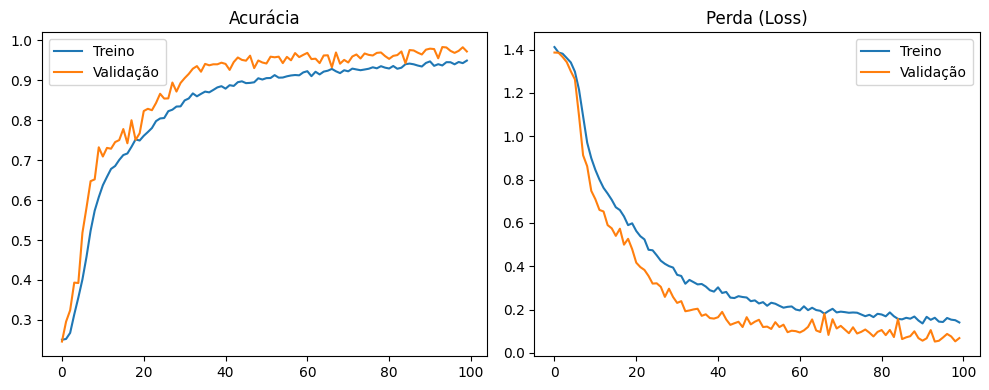

In [8]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.pdf")
plt.show()

# AVALIAÇÃO DO MODELO

Found 2487 files belonging to 4 classes.
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Accuracy: 0.8754

Classification Report:
               precision    recall  f1-score   support

  EOSINOPHIL       0.92      0.83      0.87       623
  LYMPHOCYTE       1.00      1.00      1.00       620
    MONOCYTE       1.00      0.75      0.86       620
  NEUTROPHIL       0.69      0.93      0.79       624

    accuracy                           0.88      2487
   macro avg       0.90      0.88      0.88      2487
weighted avg       0.90      0.88      0.88      2487



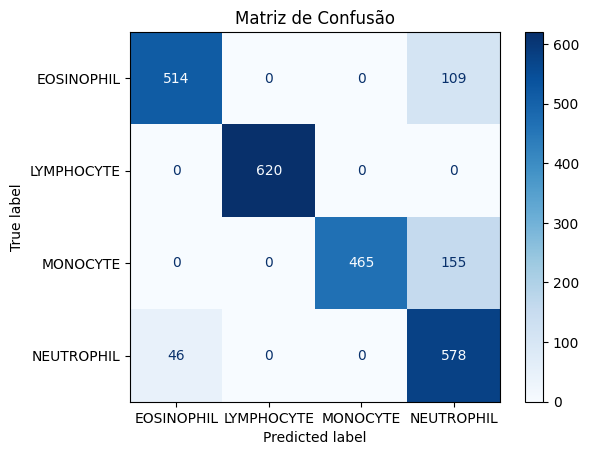

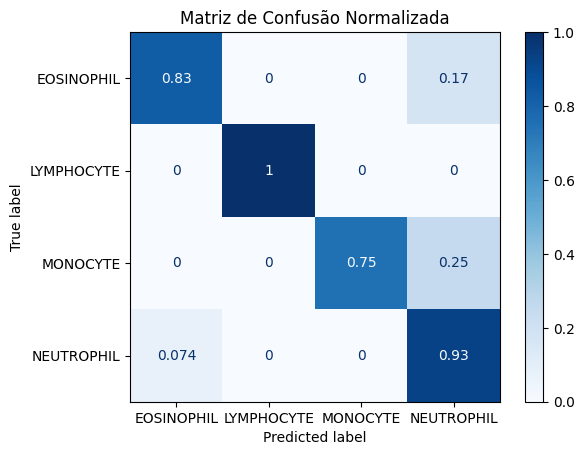

In [9]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=SEED,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    shuffle=False,
    labels='inferred'
).prefetch(tf.data.AUTOTUNE)

# Carrega o melhor modelo
best_model = tf.keras.models.load_model('best_model.keras')

# Predições diretas
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = np.argmax(best_model.predict(test_ds, verbose=1), axis=1)

# Avaliação quantitativa
acc = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names, cmap='Blues')
plt.title("Matriz de Confusão")
plt.savefig("confusion_matrix.pdf")
plt.show()

# Matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names, cmap='Blues', normalize='true')
plt.title("Matriz de Confusão Normalizada")
plt.savefig("confusion_matrix_norm.pdf")
plt.show()

Printing packages and versions

In [10]:
!python --version
print("Numpy, versão ", np.__version__)
print("Tensorflow, versão ", tf.__version__)
import matplotlib
import sklearn
import keras
print("Matplotlib, versão ", matplotlib.__version__)
print("Sklearn, versão ", sklearn.__version__)
print("Keras, versão ", keras.__version__)

Python 3.12.12
Numpy, versão  2.0.2
Tensorflow, versão  2.19.0
Matplotlib, versão  3.10.0
Sklearn, versão  1.6.1
Keras, versão  3.10.0
